In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing as skl_pre
from matplotlib import gridspec
from utils import mnist_reader
from utils import helper

## This is an autoencoder implementation of the Fashion MNIST dataset with 1 hidden layer
## with ReLU activation, and binary cross entropy with sigmoid activation on the output layer.
## We evaluate the performance of 4 first order optimizers: SGD, ADAGrad, ADAM, YOGI

## Load In Data ##
Xtrain_original, Ytrain = mnist_reader.load_mnist('data/fashion', kind='train')
Xtest_original, Ytest = mnist_reader.load_mnist('data/fashion', kind='t10k')

## This downloads the dataset if not in your directory already ##
#fashion_mnist = tf.keras.datasets.fashion_mnist
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Make sure we are in the fashion mnist directory.

Xtrain = np.zeros([60000,784])
Xtest = np.zeros([10000, 784])

## Standardize Features to [0,1]##
scaler = skl_pre.MinMaxScaler()
Xtrain_original = scaler.fit_transform(Xtrain_original)

Xtest_original = scaler.transform(Xtest_original)
Xtrain = Xtrain_original.T
Xtest = Xtest_original.T

In [2]:

## Given dimensions of input neuron "d", number of neurons in hidden layer "n1", creates an
## autoencoder class with ndarray weights W1, b1, W2, b2 (all dimensions are listed in __init__ portion)
## along with parameters that will be used in the gradient step. (i.e. nuP_W1, nuP_W2) More on this in the optimizer function.
## Uses Binary CrossEntropy Loss.
class autoencoder:
    def __init__(self, d, n1):
        self.d = d
        self.n1 = n1
        self.b1 = np.zeros(n1)
        self.b2 = np.zeros(d)
        dom = np.sqrt(6/(d + n1))
        self.W1 = np.random.uniform(-dom, dom,[d, n1])
        self.W2 = np.random.uniform(-dom, dom,[n1, d])
        self.t = 0 # timestep
        self.nuP_W1 = np.zeros([d, n1])
        self.nuP_W2 = np.zeros([n1,d])
        self.hP_W1 = np.zeros([d, n1])
        self.hP_W2 = np.zeros([n1, d])
        self.nuP_b1 = np.zeros(n1)
        self.nuP_b2 = np.zeros(d)
        self.hP_b1 = np.zeros(n1)
        self.hP_b2 = np.zeros(d)
        
## ReLU Activation, for hidden layer 1
    def h1(self, a):
        return np.maximum(0,a)
## Sigmoid activation, for output layer
    def h2(self, a):
        return 1/(1+np.exp(-a))
## Derivative of Sigmoid
    def dh2(self, a):
        return np.multiply( self.h1(a),1-self.h1(a))
## Derivative of ReLU
    def dh1(self, a):
    ## for simplicity, 0 values are given the subderivative of 1
        return np.where( a >= 0, 1, 0)

## given an ndarray Xbatch, a minibatch of X, returns the Binary Cross Entropy Loss of our current Neural Net.
    def loss(self, Xbatch): 
        int_m = Xbatch.shape[1]
        ones_m = np.zeros(int_m)
        O1 = self.h1((self.W1).T@Xbatch + np.outer(self.b1,ones_m))
        Y = self.h2((self.W2).T@O1 + np.outer(self.b2, ones_m))
        lnY = np.log(Y)
        oneminuslnY = np.log(1-Y)
        return -(np.sum(np.multiply(Xbatch, lnY) \
                        + np.multiply( (1-Xbatch), oneminuslnY)))/(self.d*int_m)
## Given Ybatch, the batch labels of Xbatch, returns the gradient of the Binary Cross Entropy Loss.
    def dloss(self, Ybatch):
        return np.divide((Ybatch - self.Xbatch), (np.multiply(Ybatch, (1-Ybatch))))
## Forward step of Neural Network.
    def forward(self, Xbatch):
        self.Xbatch = Xbatch
        int_m = Xbatch.shape[1]
        ones_m = np.ones(int_m)
        self.a1 = (self.W1).T@Xbatch + np.outer(self.b1, ones_m.T)
        self.o1 = self.h1(self.a1)
        self.a2 = (self.W2).T@self.o1 + np.outer(self.b2, ones_m.T)
        self.o2 = self.h2(self.a2)
## Backpropagation step of Neural Network.
    def backward(self):
        delta_o = np.multiply(self.dloss(self.o2), self.dh2(self.o2)) 
        int_m = delta_o.shape[1]
        ones_m = np.ones(int_m)
        self.dW2 = (self.o1@delta_o.T)/int_m ## n1 x d
        self.db2 = (delta_o @ ones_m)/int_m
        delta_h = np.multiply((self.W2@delta_o),self.dh1(self.o1))
        self.dW1 = (self.Xbatch@delta_h.T)/int_m
        self.db1 = (delta_h @ ones_m)/int_m

## Given parameters alpha (stepsize), rho1 = 0.9 (momentum term), rho2 = 0.999 (EMA term), delta = 10^{-8} (adaptivity parameter)
## performs a gradient step using ADAM. 
## nuP term can be considered the m_t term according to the paper, which is updated with rho1
## hP term can be considered the v_t term according to the paper, which is updated with rho2.

    def adam_step(self, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-8):
        self.t += 1
        ## "momentum term"
        self.nuP_W2 = rho1*self.nuP_W2 + (1-rho1)*self.dW2
        self.nuP_W1 = rho1*self.nuP_W1 + (1-rho1)*self.dW1
        self.nuP_b2 = rho1*self.nuP_b2 + (1-rho1)*self.db2
        self.nuP_b1 = rho1*self.nuP_b1 + (1-rho1)*self.db1
        ## "curvature/ Exponential Moving Average update"
        self.hP_W2 = rho2*self.hP_W2 + (1-rho2)*(self.dW2**2)
        self.hP_W1 = rho2*self.hP_W1 + (1-rho2)*(self.dW1**2)
        self.hP_b2 = rho2*self.hP_b2 + (1-rho2)*(self.db2**2)
        self.hP_b1 = rho2*self.hP_b1 + (1-rho2)*(self.db1**2)
        ## debias first term
        nuP_W2_hat = self.nuP_W2/(1 - (rho1**self.t))
        nuP_W1_hat = self.nuP_W1/(1 - (rho1**self.t))
        nuP_b2_hat = self.nuP_b2/(1 - (rho1**self.t))
        nuP_b1_hat = self.nuP_b1/(1 - (rho1**self.t))
        ## debias second term
        hP_W2_hat = self.hP_W2/(1 - (rho2**self.t))
        hP_W1_hat = self.hP_W1/(1 - (rho2**self.t))
        hP_b2_hat = self.hP_b2/(1 - (rho2**self.t))
        hP_b1_hat = self.hP_b1/(1 - (rho2**self.t))
        ## gradient step
        self.W2 -= alpha*np.divide(nuP_W2_hat, (np.sqrt(hP_W2_hat) + delta))
        self.b2 -= alpha*np.divide(nuP_b2_hat, (np.sqrt(hP_b2_hat) + delta))
        self.W1 -= alpha*np.divide(nuP_W1_hat, (np.sqrt(hP_W1_hat) + delta))
        self.b1 -= alpha*np.divide(nuP_b1_hat, (np.sqrt(hP_b1_hat) + delta))
        
## Given parameters alpha (initial stepsize), "a" decrement parameter for our stepsize ==> eta = alpha/(1 + a*t)
## performs a gradient step using SGD.
    def SGD_step(self, alpha=0.0001, a = 0.001):
        self.t += 1
        ## gradient step
        eta = alpha/(1 + a*self.t)
        self.W2 -= eta*self.dW2
        self.b2 -= eta*self.db2
        self.W1 -= eta*self.dW1
        self.b1 -= eta*self.db1
        
        
## Given parameters alpha (stepsize), rho1 = 0.9 (momentum term), rho2 = 0.999 (EMA term), delta = 10^{-8} (adaptivity parameter)
## performs a gradient step using YOGI.
    def yogi_step(self, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-3):
        self.t += 1
        ## "momentum term"
        self.nuP_W2 = rho1*self.nuP_W2 + (1-rho1)*self.dW2
        self.nuP_W1 = rho1*self.nuP_W1 + (1-rho1)*self.dW1
        self.nuP_b2 = rho1*self.nuP_b2 + (1-rho1)*self.db2
        self.nuP_b1 = rho1*self.nuP_b1 + (1-rho1)*self.db1
        ## "curvature"
        self.hP_W2 = self.hP_W2 - (1-rho2)*np.sign(self.hP_W2 - self.dW2**2)*(self.dW2**2)
        self.hP_b2 = self.hP_b2 - (1-rho2)*np.sign(self.hP_b2 - self.db2**2)*(self.db2**2)
        self.hP_W1 = self.hP_W1 - (1-rho2)*np.sign(self.hP_W1 - self.dW1**2)*(self.dW1**2)
        self.hP_b1 = self.hP_b1 - (1-rho2)*np.sign(self.hP_b1 - self.db1**2)*(self.db1**2)
        ## debias first term
        nuP_W2_hat = self.nuP_W2/(1 - (rho1**self.t))
        nuP_W1_hat = self.nuP_W1/(1 - (rho1**self.t))
        nuP_b2_hat = self.nuP_b2/(1 - (rho1**self.t))
        nuP_b1_hat = self.nuP_b1/(1 - (rho1**self.t))
        ## debias second term
        hP_W2_hat = self.hP_W2/(1 - (rho2**self.t))
        hP_W1_hat = self.hP_W1/(1 - (rho2**self.t))
        hP_b2_hat = self.hP_b2/(1 - (rho2**self.t))
        hP_b1_hat = self.hP_b1/(1 - (rho2**self.t))
        ## gradient step
        self.W2 -= alpha*np.divide(nuP_W2_hat, (np.sqrt(hP_W2_hat) + delta))
        self.b2 -= alpha*np.divide(nuP_b2_hat, (np.sqrt(hP_b2_hat) + delta))
        self.W1 -= alpha*np.divide(nuP_W1_hat, (np.sqrt(hP_W1_hat) + delta))
        self.b1 -= alpha*np.divide(nuP_b1_hat, (np.sqrt(hP_b1_hat) + delta))
        

In [3]:
yogi_trainloss = []
yogi_testloss = []
adam_trainloss = []
adam_testloss = []
d = 784
n1 = 100
###################
## YOGI TRAINING ##
###################
ntrain = Xtrain.shape[0]
numepochs = 20
batchsize = 25
numsplits = int(np.ceil(ntrain/batchsize))
np.random.seed(20)
ae = autoencoder(d, n1)
for e in range(numepochs):
    print(" Training loss [%d/%d]: %.5f" % (e+1, numepochs, ae.loss(Xtrain)))
    yogi_trainloss.append(ae.loss(Xtrain))
    yogi_testloss.append(ae.loss(Xtest))
    minibatches = np.array_split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.yogi_step()

 Training loss [1/20]: 0.69750
 Training loss [2/20]: 0.47395
 Training loss [3/20]: 0.40910
 Training loss [4/20]: 0.38925
 Training loss [5/20]: 0.37750
 Training loss [6/20]: 0.36561
 Training loss [7/20]: 0.36597
 Training loss [8/20]: 0.36186
 Training loss [9/20]: 0.35088
 Training loss [10/20]: 0.35180
 Training loss [11/20]: 0.34919
 Training loss [12/20]: 0.35009
 Training loss [13/20]: 0.34595
 Training loss [14/20]: 0.34903
 Training loss [15/20]: 0.34859
 Training loss [16/20]: 0.34614
 Training loss [17/20]: 0.34458
 Training loss [18/20]: 0.34264
 Training loss [19/20]: 0.34459
 Training loss [20/20]: 0.34856


In [4]:
d = 784
n1 = 100
ntrain = Xtrain.shape[0]
numepochs = 20
batchsize = 25
numsplits = int(np.ceil(ntrain/batchsize))
np.random.seed(20)
###################
## ADAM TRAINING ##
###################
ae = autoencoder(d, n1)
for e in range(numepochs):
    print(" Training loss [%d/%d]: %.5f" % (e+1, numepochs, ae.loss(Xtrain)))
    adam_trainloss.append(ae.loss(Xtrain))
    adam_testloss.append(ae.loss(Xtest))
    minibatches = np.array_split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.adam_step()

 Training loss [1/20]: 0.69750
 Training loss [2/20]: 0.47263
 Training loss [3/20]: 0.40766
 Training loss [4/20]: 0.38823
 Training loss [5/20]: 0.37660
 Training loss [6/20]: 0.36461
 Training loss [7/20]: 0.36552
 Training loss [8/20]: 0.36140
 Training loss [9/20]: 0.35000
 Training loss [10/20]: 0.35112
 Training loss [11/20]: 0.34924
 Training loss [12/20]: 0.34983
 Training loss [13/20]: 0.34603
 Training loss [14/20]: 0.34928
 Training loss [15/20]: 0.34962
 Training loss [16/20]: 0.34676
 Training loss [17/20]: 0.34490
 Training loss [18/20]: 0.34353
 Training loss [19/20]: 0.34444
 Training loss [20/20]: 0.34831


In [5]:
sgd_trainloss = []
sgd_testloss = []
d = 784
n1 = 100
ntrain = Xtrain.shape[0]
numepochs = 20
batchsize = 25
numsplits = int(np.ceil(ntrain/batchsize))
np.random.seed(20)
##################
## SGD TRAINING ##
##################
ae = autoencoder(d, n1)
for e in range(numepochs):
    print(" Training loss [%d/%d]: %.5f" % (e+1, numepochs, ae.loss(Xtrain)))
    sgd_trainloss.append(ae.loss(Xtrain))
    sgd_testloss.append(ae.loss(Xtest))
    minibatches = np.array_split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.SGD_step()

 Training loss [1/20]: 0.69750
 Training loss [2/20]: 0.69120
 Training loss [3/20]: 0.68614
 Training loss [4/20]: 0.68116
 Training loss [5/20]: 0.67565
 Training loss [6/20]: 0.66927
 Training loss [7/20]: 0.66187
 Training loss [8/20]: 0.65341
 Training loss [9/20]: 0.64395
 Training loss [10/20]: 0.63369
 Training loss [11/20]: 0.62290
 Training loss [12/20]: 0.61194
 Training loss [13/20]: 0.60116
 Training loss [14/20]: 0.59088
 Training loss [15/20]: 0.58134
 Training loss [16/20]: 0.57268
 Training loss [17/20]: 0.56496
 Training loss [18/20]: 0.55821
 Training loss [19/20]: 0.55235
 Training loss [20/20]: 0.54730


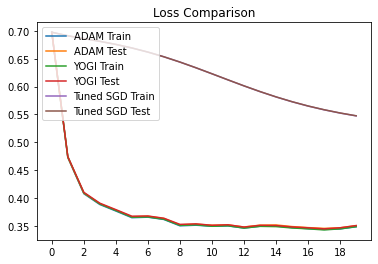

In [12]:
## Plot Loss Across All Models ##

plt.title("Loss Comparison")
plt.plot(adam_trainloss[0:20], label = "ADAM Train")
plt.plot(adam_testloss[0:20], label = "ADAM Test")
plt.plot(yogi_trainloss[0:20], label = "YOGI Train")
plt.plot(yogi_testloss[0:20], label = "YOGI Test")
plt.plot(sgd_trainloss[0:20], label = "Tuned SGD Train")
plt.plot(sgd_testloss[0:20], label = "Tuned SGD Test")
plt.xticks(np.arange(0,20,2))
plt.legend(loc = 'upper left')
plt.show()

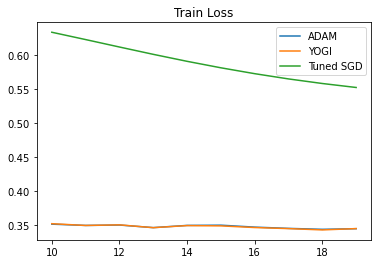

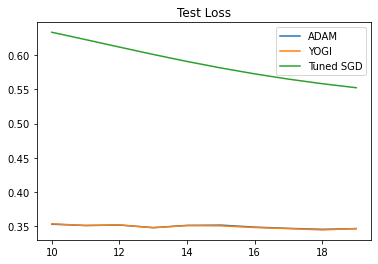

In [7]:
## Plot Train Loss Only ##
plt.title("Train Loss")
plt.plot(np.arange(10,20),adam_trainloss[9:19], label = "ADAM")
plt.plot(np.arange(10,20),yogi_trainloss[9:19], label = "YOGI")
plt.plot(np.arange(10,20),sgd_trainloss[9:19], label = "Tuned SGD")
plt.legend()
plt.show()

## Plot Test Loss Only ##
plt.title("Test Loss")
plt.plot(np.arange(10,20),adam_testloss[9:19], label = "ADAM")
plt.plot(np.arange(10,20),yogi_testloss[9:19], label = "YOGI")
plt.plot(np.arange(10,20),sgd_testloss[9:19], label = "Tuned SGD")
plt.legend()
plt.show()

In [8]:
## Directly Print Accuracies ##
print("SGD TEST LOSS:", sgd_testloss[19])
print("ADAM TEST LOSS:", adam_testloss[19])
print("YOGI TEST LOSS:", yogi_testloss[19])


SGD TEST LOSS: 0.5475352700800752
ADAM TEST LOSS: 0.35021100870752436
YOGI TEST LOSS: 0.350475262313481
